In [1]:
from google.colab import drive
drive.mount('/content/drive')

from IPython.display import clear_output

!pip install -qU catboost category_encoders shap optuna
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

import shap
import optuna
from optuna.samplers import TPESampler

import category_encoders as ce

np.random.seed(123)

In [3]:
train_root = '/content/drive/My Drive/data/autoru/autoru_total.csv'
TARGET_NAME = 'Price'

In [4]:
df = pd.read_csv(train_root)
df.drop_duplicates(inplace=True)

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MSE_scaled:\t" + str(round(mse(true_values, pred_values) / np.median(true_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values, alpha=0.6)
    plt.plot([0, 2e+7], [0, 2e+7], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save:
        if not os.path.exists('./saved'):
            os.makedirs('./saved')
        plt.savefig('./saved/' + 'report.png')
    plt.show()

def cross_validation(clf, X, y, scoring=None):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
df.sample(5)

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
36278,Mazda 626 III (GD),1996,365000.0,2.2,"Бензин, газобаллонное оборудование",115.0,2300.0,Не требует ремонта,3 или более,Оригинал,Растаможен,механическая,зелёный,универсал 5 дв.,NaN,передний,120000.0
17176,Hyundai Santa Fe III Рестайлинг,2016,174000.0,2.4,Бензин,171.0,7695.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,1830000.0
21370,Honda CR-V IV,2014,121208.0,2.0,Бензин,150.0,5100.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,коричневый,внедорожник 5 дв.,ДТП ненайдены,полный,1579000.0
15603,"Toyota Corolla IX (E120, E130)",2003,322000.0,1.6,Бензин,110.0,2750.0,Не требует ремонта,3 или более,Оригинал,Растаможен,автоматическая,синий,седан,NaN,передний,444999.0
4416,Hyundai Matrix I,2002,270000.0,1.8,Бензин,122.0,3050.0,Не требует ремонта,3 или более,Оригинал,Растаможен,автоматическая,серый,компактвэн,NaN,передний,215000.0


In [10]:
df.describe()

,Year,Mileage,V_engine,HorsePower,Tax,Price
count,35700.000000,35700.000000,35700.000000,35700.000000,35239.000000,3.570000e+04
mean,2011.029944,150702.729328,2.945423,171.928067,12394.124578,1.413787e+06
std,6.719819,95645.177437,14.640703,86.029600,20209.423408,1.741808e+06
min,1923.000000,1.000000,0.500000,11.000000,0.000000,2.500000e+04
25%,2008.000000,81380.750000,1.600000,115.000000,2925.000000,4.600000e+05
50%,2012.000000,140000.000000,2.000000,150.000000,5130.000000,8.750000e+05
75%,2016.000000,200664.000000,2.500000,200.000000,10000.000000,1.714000e+06
max,2021.000000,1000000.000000,560.000000,761.000000,292500.000000,3.999000e+07


In [11]:
df.describe(include=['object'])

,Model,EngineType,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive
count,35700,35700,35696,35698,35700,35699,35700,35700,35700,8091,35700
unique,3163,8,1,3,2,1,4,16,25,1,3
top,Ford Focus II Рестайлинг,Бензин,Не требует ремонта,3 или более,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,ДТП ненайдены,передний
freq,395,29997,35696,14979,31027,35699,19112,9479,12875,8091,19575


In [30]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35700 entries, 0 to 36905
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Model        35700 non-null  category
 1   Year         35700 non-null  int16   
 2   Mileage      35700 non-null  float32 
 3   V_engine     35700 non-null  float32 
 4   EngineType   35700 non-null  category
 5   HorsePower   35700 non-null  float32 
 6   Tax          35239 non-null  float32 
 7   State        35696 non-null  category
 8   Owners       35698 non-null  category
 9   Passport     35700 non-null  category
 10  Customs      35699 non-null  category
 11  Selector     35700 non-null  category
 12  Color        35700 non-null  category
 13  CarBodyType  35700 non-null  category
 14  Accidents    8091 non-null   category
 15  Drive        35700 non-null  category
 16  Price        35700 non-null  float32 
dtypes: category(11), float32(5), int16(1)
memory usage: 1.6 MB


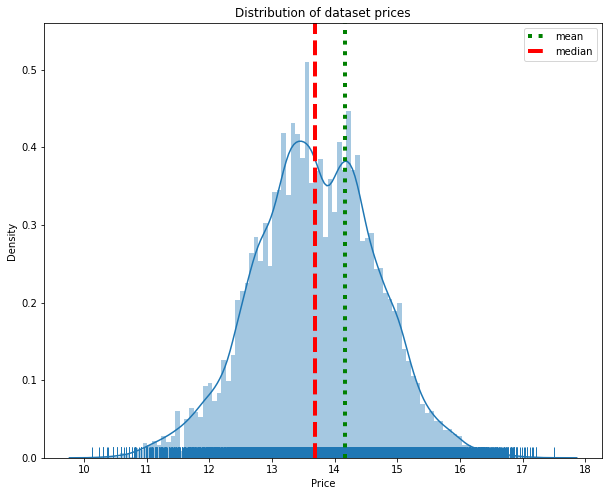

In [16]:
plt.figure(figsize = (10, 8))

sns.distplot(np.log(df[TARGET_NAME]), bins=100, rug=True)
plt.axvline(np.log(df[TARGET_NAME].mean()), label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(np.log(df[TARGET_NAME].median()), label='median', linestyle='--', color='red', linewidth=4)

plt.title('Distribution of dataset prices')
plt.legend()
plt.show()

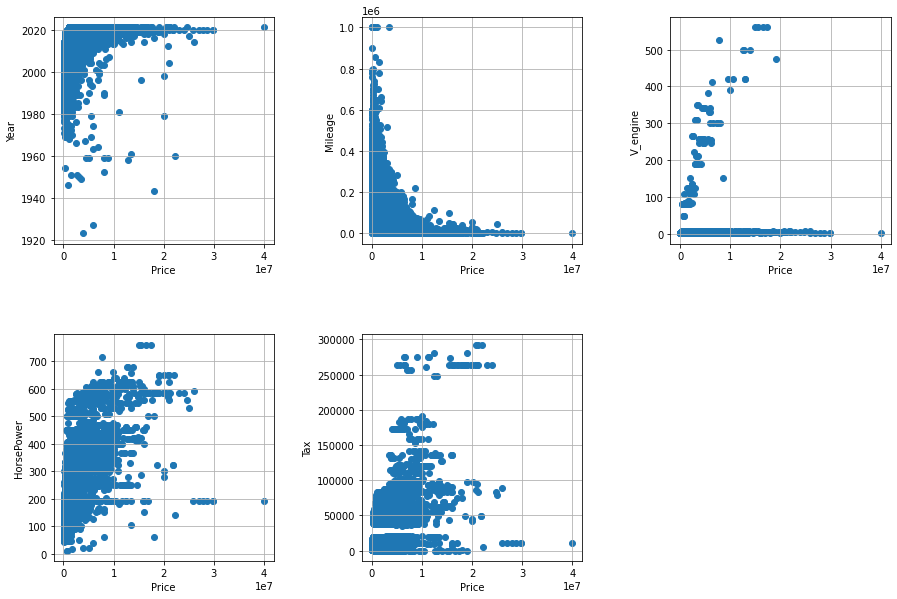

In [19]:
plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    plt.scatter(df[TARGET_NAME], df[col])
    plt.xlabel(TARGET_NAME)
    plt.ylabel(col)
    plt.grid()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

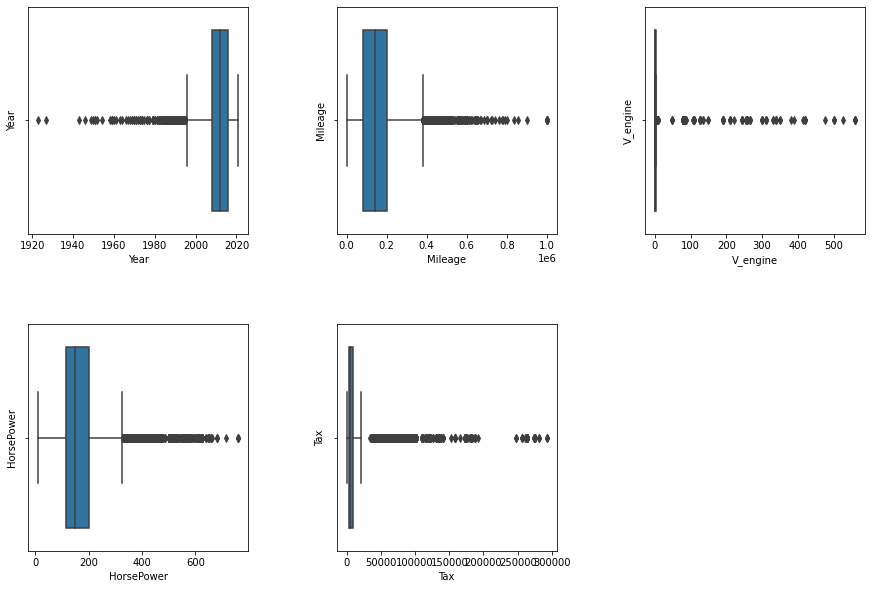

In [21]:
plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(df[col])
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [56]:
from scipy import stats
anova_list = [df.loc[df.EngineType == s, TARGET_NAME].values for s in df.EngineType.unique()]


# EngineTypes have statistical impact on target, samples are pretty large that we may not worry about norm.dist.
stats.f_oneway(*anova_list)

F_onewayResult(statistic=418.87549133598685, pvalue=0.0)

In [31]:
df = pd.read_csv(train_root)
df.drop_duplicates(inplace=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=123)
X_train.shape, X_valid.shape, X_test.shape

((24097, 16), (8033, 16), (3570, 16))

In [5]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.owners_mode = None
        self.year_miles_price = None
        self.owners_year_price = None
        self.owners_year_price_med = None

    def fit(self, X, y=None):
        X_ = pd.concat([X, y], axis=1)
        self.owners_mode = X_.Owners.mode()[0]
        self.year_miles_price = X_.groupby('Year').agg({TARGET_NAME: 'median'}).to_dict()[TARGET_NAME]
        self.owners_year_price = X_.groupby(['Year', 'Owners']).agg({TARGET_NAME: 'median'}).reset_index()
        self.owners_year_price_med = self.owners_year_price[TARGET_NAME].mean()
        self.owners_year_price.rename(columns={TARGET_NAME: 'YearOwnerPrice'}, inplace=True)

        return self

    def transform(self, X):
        X_index = X.index
        X_ = X.copy()
        # drop constant columns
        X_.drop(['State', 'Customs'], axis=1, inplace=True)

        # take shorter model name
        X_['Model'] = X_.Model.apply(lambda x: ' '.join(x.split()[:3]))

        # Electro engines [in original dataset electro_V == Hp]
        X_.loc[X.EngineType == 'Электро', 'V_engine'] /= 100

        # fill nans in taxes
        condition = ((X_.HorsePower <= 100) & (X_.Tax.isna()))
        X_.loc[condition, 'Tax'] = X_.loc[condition, 'HorsePower'] * 2.5
        condition = ((X_.HorsePower.between(101, 150)) & (X_.Tax.isna()))
        X_.loc[condition, 'Tax'] = X_.loc[condition, 'HorsePower'] * 3.5
        condition = ((X_.HorsePower.between(151, 200)) & (X_.Tax.isna()))
        X_.loc[condition, 'Tax'] = X_.loc[condition, 'HorsePower'] * 5
        condition = ((X_.HorsePower.between(201, 250)) & (X_.Tax.isna()))
        X_.loc[condition, 'Tax'] = X_.loc[condition, 'HorsePower'] * 7.5
        condition = ((X_.HorsePower > 250) & (X_.Tax.isna()))
        X_.loc[condition, 'Tax'] = X_.loc[condition, 'HorsePower'] * 15

        # Year bins
        X_['Year_bin'] = 1
        X_.loc[X.Year < 1981, 'Year_bin'] = 11
        X_.loc[X.Year == 2021, 'Year_bin'] = 15
        X_.loc[X.Year.between(2018, 2020), 'Year_bin'] = 12
        X_.loc[X.Year.between(2016, 2017), 'Year_bin'] = 9
        X_.loc[X.Year.between(2012, 2015), 'Year_bin'] = 7
        X_.loc[X.Year.between(2008, 2011), 'Year_bin'] = 5
        X_.loc[X.Year.between(1995, 2007), 'Year_bin'] = 3
        X_.loc[X.Year.between(1981, 1994), 'Year_bin'] = 1

        X_.Owners.fillna(self.owners_mode, inplace=True)

        # nans in Accidents
        X_.loc[~X_.Accidents.isna(), 'Accidents'] = 1
        X_.Accidents.fillna(0, inplace=True)
        X_.Accidents = X_.Accidents.astype(np.uint8)

        # new features
        X_ = self._create_features(X_)

        X_ = reduce_memory(X_)
        X_.index = X_index

        return X_

    def _create_features(self, X):
        X['TaxPower'] = X.Tax / X.HorsePower * 10
        X['YearMilesPrice'] = X.Year.map(self.year_miles_price) / X.Mileage

        X = X.merge(self.owners_year_price, on=['Year', 'Owners'], how='left')
        X.YearOwnerPrice.fillna(self.owners_year_price_med, inplace=True)
        X.YearOwnerPrice = X.YearOwnerPrice / X.Mileage

        return X

class ColumnSelector(BaseEstimator, TransformerMixin):
    # class to select particular columns from input dataFrame
    def __init__(self, columns, select=False, steps=2):
        self.columns = columns
        self.select = select
        self.steps = steps
        
    def fit(self, X, y=None):
        if self.select:
            summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=self.steps)
            self.columns = summary['selected_features_names']
        elif self.columns is None and isinstance(X, pd.DataFrame):
            self.columns = X.columns.tolist()
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

In [32]:
selected_by_shap = ['Model', 'Year', 'Mileage', 'V_engine', 'EngineType', 'HorsePower', 'Tax', 'Owners', 
                    'Selector', 'Color', 'CarBodyType', 'Drive']

pipe = Pipeline(steps=[('preprocessor', Preprocessor()),
                       ('selector', ColumnSelector(columns=None)) # selected_by_shap / select=True
                       ])

X_train = pipe.fit_transform(X_train, y_train)
X_valid = pipe.transform(X_valid)
X_test = pipe.transform(X_test)

Memory usage of dataframe is 3.33 MB
Memory usage after optimization is: 1.20 MB
Decreased by 63.9%
Memory usage of dataframe is 1.11 MB
Memory usage after optimization is: 0.42 MB
Decreased by 62.4%
Memory usage of dataframe is 0.49 MB
Memory usage after optimization is: 0.21 MB
Decreased by 58.1%


In [33]:
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [122]:
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=200, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=X_train.shape[1] - 2,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=2)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features: ['Model', 'Year', 'Mileage', 'V_engine', 'EngineType', 'HorsePower', 'Tax', 'Owners', 'Selector', 'Color', 'CarBodyType', 'Drive']


In [10]:
# constant model parameters
params_model = {
    'eval_metric': 'R2', 
    'iterations': 1000,
    'silent': True,
    'one_hot_max_size': 15, # 30
    'early_stopping_rounds': 10,
    'grow_policy': 'SymmetricTree', # Depthwise, Lossguide
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    }

In [11]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    }
    param_trials.update(params_model)
    opt_model = CatBoostRegressor(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred_tr = opt_model.predict(X_train)
    y_pred = opt_model.predict(X_valid)
    score_tr = r2_score(y_train, y_pred_tr)
    score_val = r2_score(y_valid, y_pred)
    
    return np.abs(score_tr - score_val)  # score_val # we run min score difference to find a way to not overfit

In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123), direction="minimize") # maximize in case score_val
study.optimize(objective, n_trials=100, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [34]:
model_params = {
                'depth': 6, # 6
                'learning_rate': 0.4178777938779631, # 0.2178777938779631 / 0.46046977406739936
                'l2_leaf_reg': 4.802082115766556, # 2.802082115766556 / 2.035782731010226
                'bagging_temperature': 1.4595074288040872, # / 2.663566424260357
                'subsample': 0.9042456059974736, # 0.9042456059974736 / 0.9976023844071865
                'colsample_bylevel': 0.5491277529775006, # 0.9491277529775006 / 0.9684633882412697
                'boosting_type': 'Plain', # Ordered
                'eval_metric': 'R2', 
                'iterations': 1000,
                'silent': True,
                'one_hot_max_size': 16, # 30
                'early_stopping_rounds': 5,
                'grow_policy': 'SymmetricTree', # Depthwise, Lossguide
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
}

R2 train: 0.966
R2:	0.88
MAE:	214503.162
RMSE:	580560.567
MSE:	337050572270.801
MSE_scaled:	381926.994


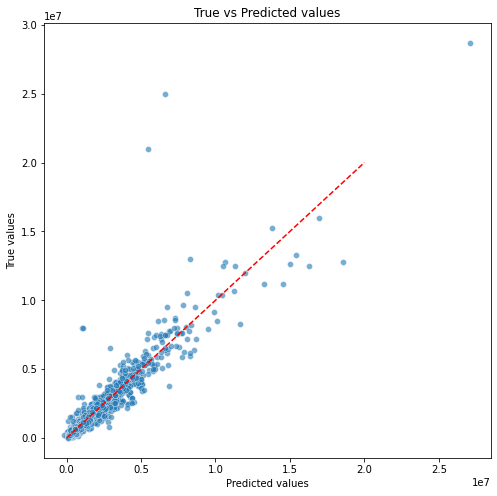

In [35]:
catboost_reg = CatBoostRegressor(**model_params)
catboost_reg.fit(train_pool, eval_set=valid_pool)

train_pred = catboost_reg.predict(X_train)
test_pred = catboost_reg.predict(X_test)

print(f'R2 train: {r2_score(y_train, train_pred):.3f}')
evaluate_preds(y_test, test_pred)

In [41]:
shap.initjs()
shap_values = catboost_reg.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[np.random.randint(len(X_test))-2,:])

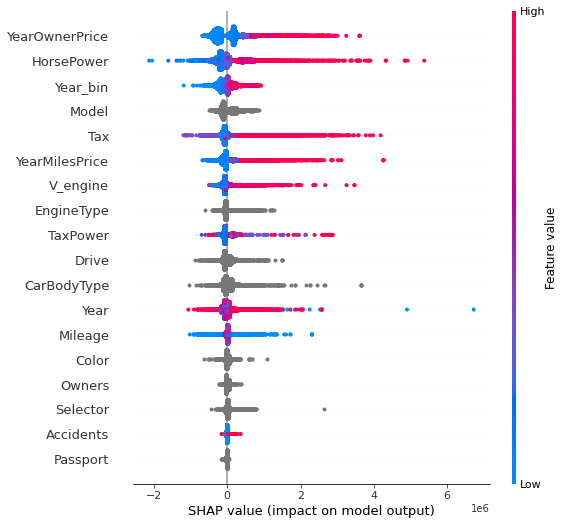

In [42]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

LGBM

In [6]:
df = pd.read_csv(train_root)
df.drop_duplicates(inplace=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=123)

cols_one_hot = ['EngineType', 'Owners', 'Selector', 'Color', 'Drive']
cols_encode = ['Model', 'CarBodyType',]
binary_cols = ['Passport',]

columns_transformer = ColumnTransformer(transformers=[('one_hot', ce.one_hot.OneHotEncoder(), cols_one_hot),                                                      
                                                      ('binary', ce.binary.BinaryEncoder(), binary_cols),
                                                      ('cat_enc', ce.m_estimate.MEstimateEncoder(random_state=123, m=5), cols_encode),
                                                      ], 
                                        remainder='passthrough')

pipe = Pipeline(steps=[('preprocessor', Preprocessor()),
                       ('col_transformer', columns_transformer),
                       ])

X_train_ = pipe.fit_transform(X_train, y_train)
X_valid_ = pipe.transform(X_valid)
X_test_ = pipe.transform(X_test)

Memory usage of dataframe is 3.33 MB
Memory usage after optimization is: 1.20 MB
Decreased by 63.9%
Memory usage of dataframe is 1.11 MB
Memory usage after optimization is: 0.42 MB
Decreased by 62.4%
Memory usage of dataframe is 0.49 MB
Memory usage after optimization is: 0.21 MB
Decreased by 58.1%


In [7]:
def r2_metric(y_true, y_pred):
    return 'R2', r2_score(y_true, y_pred), True  # name, metric_value, is_higher_better

model_params = {
                'objective': 'regression',
                'n_estimators': 800,
                'n_jobs': -1,
                'random_state': 123,
                'metric': 'custom'
}
fit_params = {'early_stopping_rounds': 20,  
              'eval_set': [(X_valid_, y_valid)],  
              'eval_metric': r2_metric,
              'verbose': False
}

In [69]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 60, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 120, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    param_trials.update(model_params)
    opt_model = LGBMRegressor(**param_trials)
    opt_model.fit(X_train_, y_train, **fit_params)
    
    y_pred = opt_model.predict(X_valid_)
    score = r2_score(y_valid, y_pred)
    
    return score # cross_val_score

In [72]:
# base!
l = LGBMRegressor(verbose=0)
l.fit(X_train_, y_train)
print(r2_score(y_train, l.predict(X_train_)))
print(r2_score(y_test, l.predict(X_test_)))

0.9703636058636194
0.8890233496227216


In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [11]:
selected_params = {
                   'max_depth': 6, # 8
                   'learning_rate': 0.22881296435646914,
                   'reg_alpha': 1.469270582317852,
                   'reg_lambda': 4.705629454186699,
                   'num_leaves': 251,
                   'subsample': 0.9552140058405192,
                   'colsample_bytree': 0.4430038603128556,
                   'max_bin': 156,
                   'min_child_samples': 120,
                   'min_child_weight': 0.052277428391311165,
                   'boosting_type': 'gbdt', 
                   'objective': 'regression',
                   'n_estimators': 800,
                   'n_jobs': -1,
                   'random_state': 123,
                   'metric': 'custom'
}

fit_params = {'model__early_stopping_rounds': 20,  
              'model__eval_set': [(X_valid_, y_valid)],  
              'model__eval_metric': r2_metric,
              'model__verbose': False
}  

In [12]:
df = pd.read_csv(train_root)
df.drop_duplicates(inplace=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=123)

pipe = Pipeline(steps=[('preprocessor', Preprocessor()),
                       ('col_transformer', columns_transformer),
                       ('model', LGBMRegressor(**selected_params))
                       ])

pipe.fit(X_train, y_train, **fit_params)
print()

Memory usage of dataframe is 3.33 MB
Memory usage after optimization is: 1.20 MB
Decreased by 63.9%



R2 train: 0.969
R2:	0.888
MAE:	194670.241
RMSE:	559921.791
MSE:	313512411703.01
MSE_scaled:	355254.857


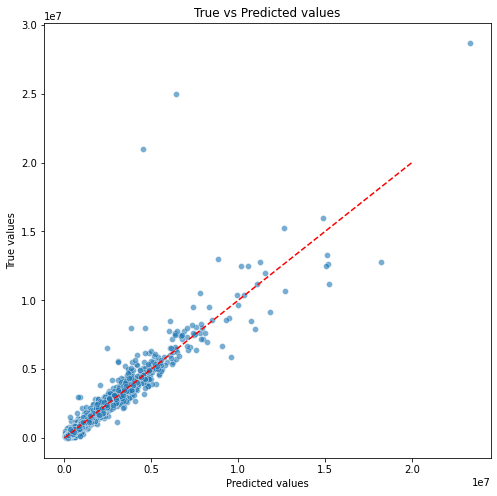

In [13]:
X_train_ = pipe[:-1].transform(X_train) # [-1] or rewrite class predict method
X_valid_ = pipe[:-1].transform(X_valid)
X_test_ = pipe[:-1].transform(X_test)
clear_output()

train_pred = pipe[-1].predict(X_train_)
test_pred = pipe[-1].predict(X_test_)

print(f'R2 train: {r2_score(y_train, train_pred):.3f}')
evaluate_preds(y_test, test_pred)

In [17]:
cross_validation(pipe, X_train, y_train, scoring='r2')

Меры правильности перекрекстной оценки: [0.9082101  0.91479856 0.91966958 0.8841971  0.94511436 0.89834573
 0.92936892 0.92415262 0.92625116 0.94729812]
Точность перекретсной оценки: 0.920 +/- 0.019


array([0.9082101 , 0.91479856, 0.91966958, 0.8841971 , 0.94511436,
       0.89834573, 0.92936892, 0.92415262, 0.92625116, 0.94729812])